In [3]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import json
import os
from  collections import Counter

import pickle

In [76]:
from IPython.display import display, Markdown
from enum import Enum
import matplotlib.pyplot as plt

SEED = 1234 # Seed for randomizing methods where relevant

class PrintType(Enum):
    SOLUTION = "✅ Solution"
    GRAPH = "📊 Graph"
    COMMENT = "💬 Comment"
    ERROR = "❌ Error"

def printmd(type, string):
    prefix = type.value
    display(Markdown(f"> **{prefix}**: {string}"))


# Create graph

In [7]:
video_game_genres = [
    "Action games", "Action-adventure games", "Adventure games", "Art games", "Aviation video games", 
    "Battle royale games", "Beat 'em ups", 
    "Construction and management simulation games", 
    "Digital tabletop games", "Dress-up video games", 
    "Educational video games", "Eroge", 
    "Fighting games", 
    "Hack and slash games", "Health video games", "Horror video games", 
    "Immersive sims", "Incremental games", "Interactive movie video games", 
    "Martial arts video games", "Metroidvania games", "Music video games", "Mystery video games", 
    "Neo-noir video games", "Non-games", 
    "Open-world video games", 
    "Party video games", "Pinball video games", "Platformers", "Psychological horror games", "Puzzle video games", 
    "Quiz video games", 
    "Racing video games", "Roguelike video games", "Role-playing video games", 
    "Sandbox games", "Shooter games", "Simulation video games", "Social deduction video games", "Soulslike video games", "Sports video games", "Stealth video games", "Strategy video games", "Survival horror video games", "Survival video games", 
    "Tactical role-playing video games", "Typing video games", 
    "Vehicle-building video games"
]


In [10]:
def get_or_create_value(function_to_apply, file_path):
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the value from the file
        with open(file_path, 'r') as file:
            value = json.load(file)
    else:
        # Call the function to create the value
        value = function_to_apply()
        # Save the value to the file
        with open(file_path, 'w') as file:
            json.dump(value, file)
    
    return value

game_data = get_or_create_value(lambda: {}, "../data/game_data_with_vader_sentiment.json")

In [15]:
# Get year property
selected_attributes = ['outpages', 'year', 'country of development', 'sentiment', 'genres']
categorie = []
new_game_data = dict()
for g in game_data:
    new_game_data[g] = dict()
    new_game_data[g]['outpages'] = game_data[g]['outpages']
    new_game_data[g]['year'] = int(game_data[g]['categorie'].split(' ')[0])
    new_game_data[g]['country of development'] = game_data[g]['country of development']
    new_game_data[g]['sentiment'] = game_data[g]['sentiment']
    new_game_data[g]['genres'] = [el for el in game_data[g]['categories'] if el in video_game_genres]
    

In [17]:
import networkx as nx

def create_directed_graph(data, selected_attributes = []):
    # Create a directed graph
    G = nx.DiGraph()
    # Iterate over dictionary items
    for node, properties in data.items():
        selected_attributes_dict = dict()
        for att in selected_attributes:
            selected_attributes_dict[att] = properties[att]
        # Add the node to the graph
        G.add_node(node, **selected_attributes_dict)
        # Add edges from this node to each node in 'outpages'
        for outpage in properties.get('outpages', []):
            G.add_edge(node, outpage)

    return G

In [18]:
DIRECTED_G = create_directed_graph(new_game_data, selected_attributes)

In [19]:
# import pickle

# # save graph object to file
pickle.dump(DIRECTED_G, open('../data/graph.pickle', 'wb'))

# Graph analysis

In [9]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import scienceplots
import pickle
import numpy as np

In [2]:
# Load graph object from pickle file that we saved in lecture 4
DIRECTED_G = pickle.load(open('../data/graph.pickle', 'rb'))
UNDIRECTED_G = DIRECTED_G.copy().to_undirected()

In [115]:
print(f"Nodes: {DIRECTED_G.number_of_nodes()}")
print(f"Directed Edges: {DIRECTED_G.number_of_edges()}")
print(f"Undirected Edges: {UNDIRECTED_G.number_of_edges()}")

Nodes: 18823
Directed Edges: 33989
Undirected Edges: 29528


In [118]:
MAIN_COMPONENT = UNDIRECTED_G.subgraph(max(nx.connected_components(UNDIRECTED_G), key=len))
print(f"Nodes: {MAIN_COMPONENT.number_of_nodes()}")
print(f"Edges: {MAIN_COMPONENT.number_of_edges()}")

Nodes: 12687
Edges: 28259


## Degree analysis

In [120]:
most_connected_in = sorted(dict(DIRECTED_G.in_degree).items(), key=lambda x:x[1], reverse=True)[0:5]
most_connected_in

[('Pac-Man', 172),
 ('Tetris', 126),
 ('Arcade Archives', 119),
 ('Super Mario Bros.', 111),
 ('Super Smash Bros. Ultimate', 110)]

In [122]:
most_connected_out = sorted(dict(DIRECTED_G.out_degree).items(), key=lambda x:x[1], reverse=True)[0:5]
most_connected_out

[('Pac-Man', 65),
 ('Rare Replay', 33),
 ('Donkey Kong (arcade game)', 30),
 ('Street Fighter II', 30),
 ('Donkey Kong Country', 29)]

In [78]:
import powerlaw
in_alpha = powerlaw.Fit(list(dict(DIRECTED_G.in_degree).values())).alpha
out_alpha = powerlaw.Fit(list(dict(DIRECTED_G.out_degree).values())).alpha
total_alpha = powerlaw.Fit(list(dict(DIRECTED_G.degree).values())).alpha

printmd(PrintType.SOLUTION, f'''Exponents of the degree distribution:
>    * In: {in_alpha:.2f}
>    * Out: {out_alpha:.2f}
>    * Total: {total_alpha:.2f}
''')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


> **✅ Solution**: Exponents of the degree distribution:
>    * In: 3.24
>    * Out: 7.67
>    * Total: 3.63


In [123]:
import numpy as np
import matplotlib.pyplot as plt

def degree_distribution_plot(d1, label1, d2, label2, title="", n_bins = 100, xscale="linear", yscale = "linear", fig = None, ax = None):
    # Convert input lists to Python lists
    d1 = list(d1)
    d2 = list(d2)

    # Create bins for the histogram using numpy's linspace function
    # The bins range from the minimum to the maximum of the combined d1 and d2 lists
    bins = np.linspace(min(d1+d2), max(d1+d2), n_bins)
    
    # Use numpy's histogram function to calculate the frequency and bin edges for d1 and d2
    frq1, edges1 = np.histogram(a=d1, bins=bins)
    frq2, edges2 = np.histogram(a=d2, bins=bins)

    # If no figure or axis is provided, create a new one
    if(fig == None and ax == None):
        fig, ax = plt.subplots(1, 1)

    # If a title is provided, set it as the figure's title
    if(title != ""):
        fig.suptitle(title, fontsize=16)

    # Plot the histogram for d1 and d2
    if(xscale=="linear" and yscale=="linear"):
        ax.hist(edges1[:-1], n_bins, weights=frq1, label=label1, alpha = 0.7, lw=2)
        ax.hist(edges2[:-1], n_bins, weights=frq2, label=label2, alpha = 0.7, lw=2)
    else:
        ax.plot(bins[:-1], frq1, marker="o", linestyle = 'none', label=label1, alpha = 0.7)
        ax.plot(bins[:-1], frq2, marker="o", linestyle = 'none', label=label2, alpha = 0.7)
    # Set labels for the x and y axes
    ax.set_xlabel("k")
    ax.set_ylabel("count")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.xaxis.set_minor_locator(plt.NullLocator())
 
    # Add a legend to the plot
    ax.legend()

    # Hide the bottom spine of the plot
    if xscale == "linear":
        ax.spines['bottom'].set_visible(False)

    return bins


(0.8, 1065.8733701061972)

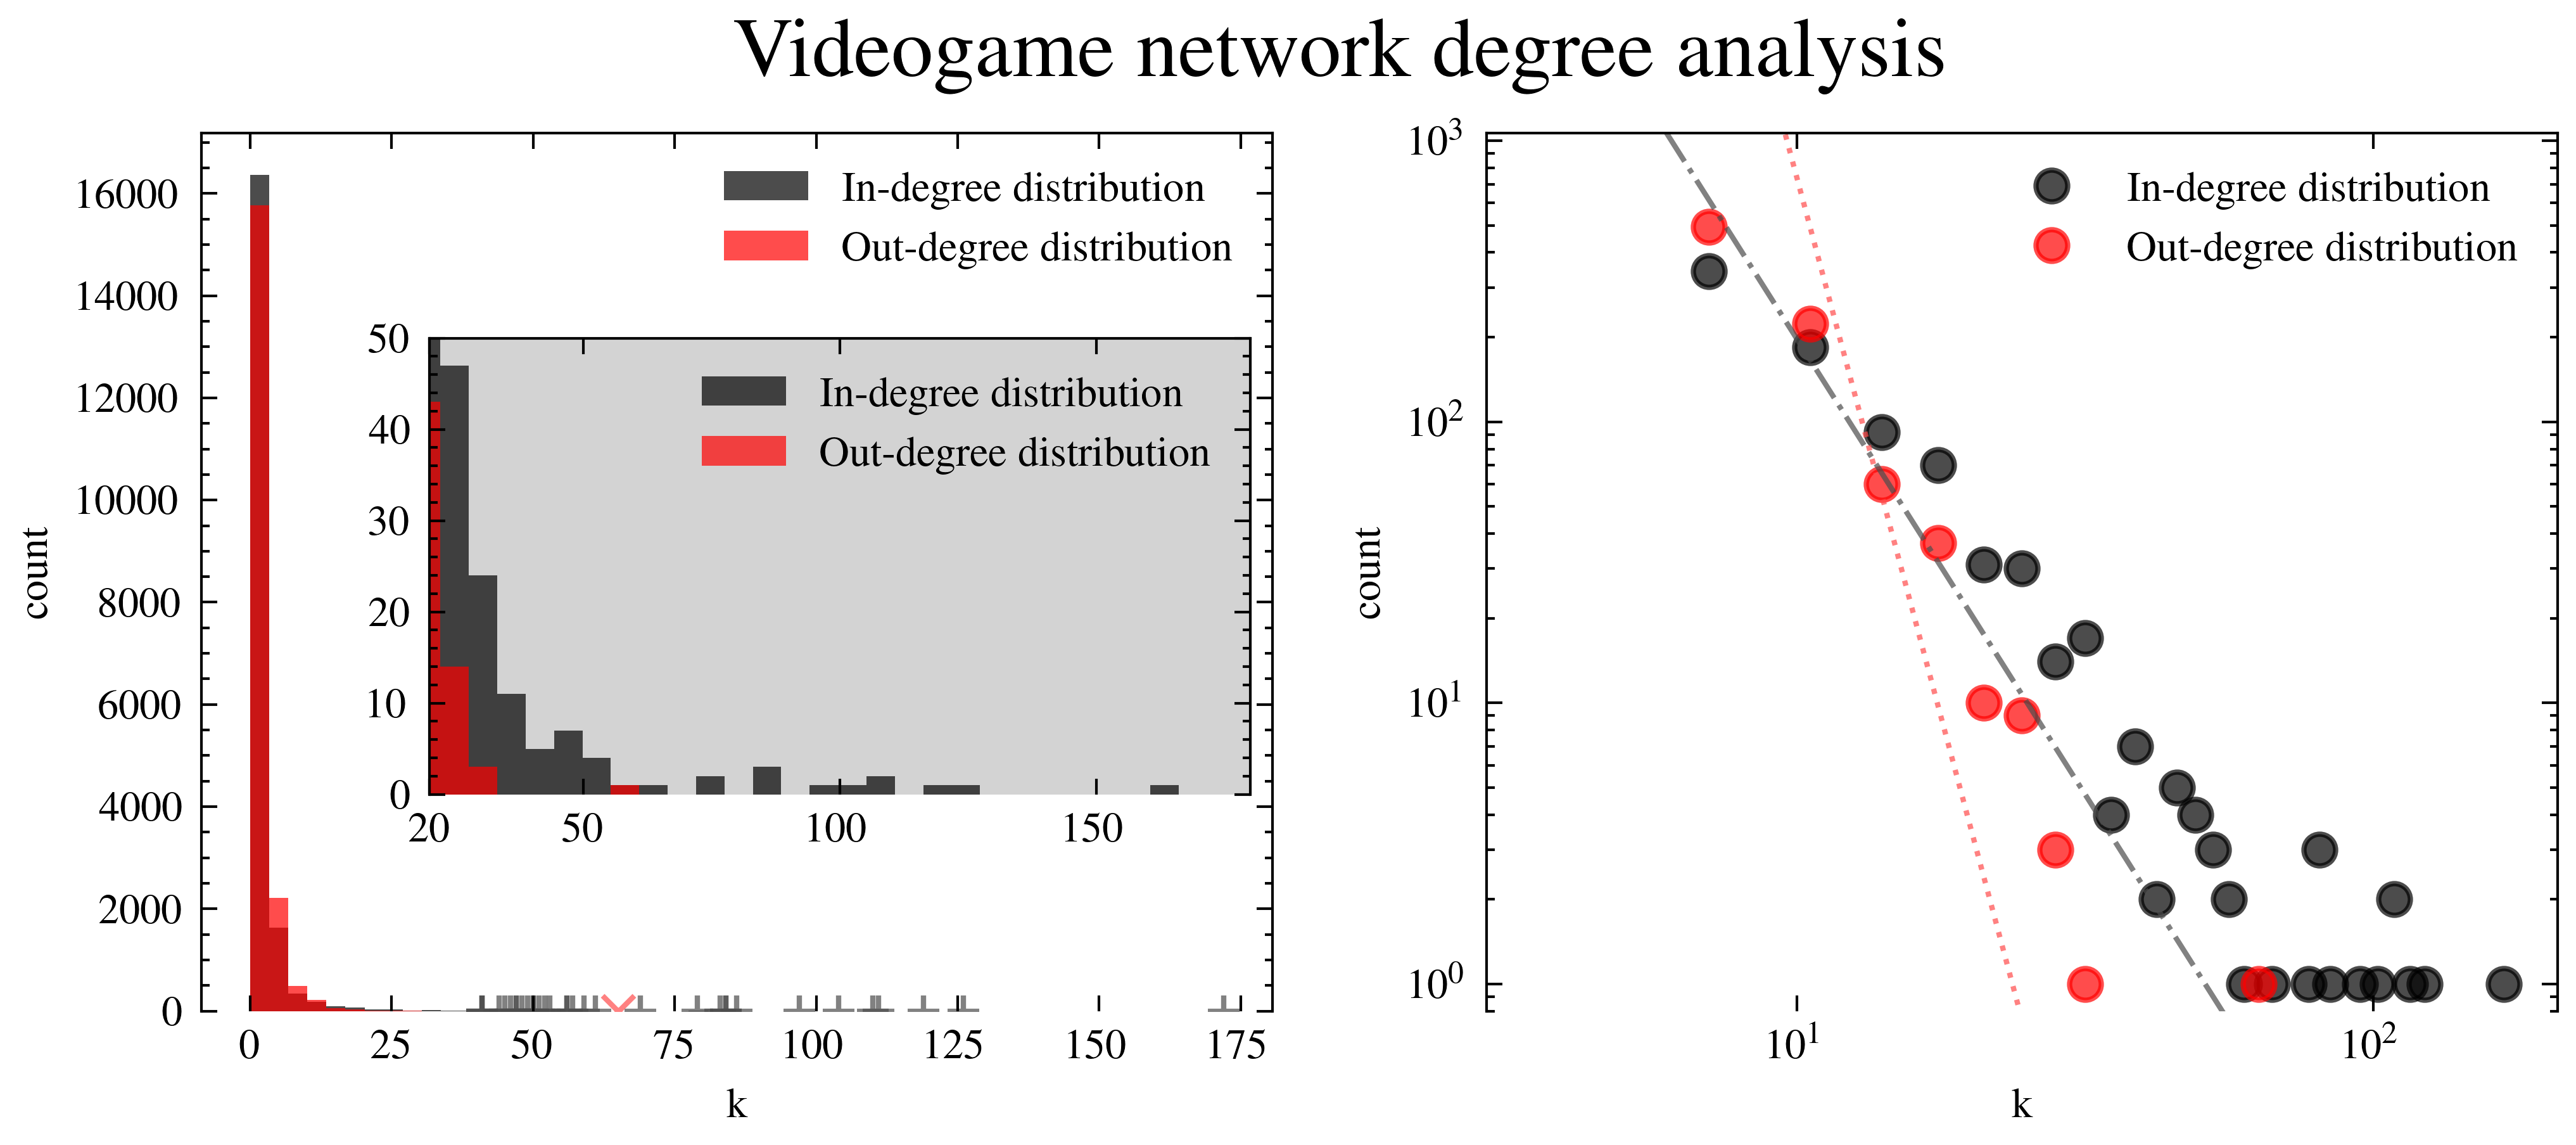

In [124]:
plt.style.use(['science','ieee'])

fig, (ax0, ax1) = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(3)
bins0 = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis', n_bins=50, fig = fig, ax=ax0
    , xscale="linear", yscale="linear"
    )

cut = 40
in_scatter = [d for d in dict(DIRECTED_G.in_degree).values() if d > cut]
out_scatter = [d for d in dict(DIRECTED_G.out_degree).values() if d > cut]
ax0.scatter(in_scatter, [0.5]*len(in_scatter), marker='+', color="#4c4c4c", alpha=0.7)
ax0.scatter(out_scatter, [0.5]*len(out_scatter), marker='x', color="#ff4c4c", alpha=0.7)
# ax0.set_xlim(0, 25)


inset_ax = fig.add_axes([0.2, 0.3, 0.27, 0.4]) 
bins = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='', n_bins=30, fig = fig, ax=inset_ax
    , xscale="linear", yscale="linear"
    )
inset_ax.set_xlim(20,180)
inset_ax.set_ylim(0,50)
inset_ax.set_facecolor('lightgrey')
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.set_xticks([20,50,100,150])

# Compare each plot
bins2 = degree_distribution_plot(dict(DIRECTED_G.in_degree).values(), "In-degree distribution", 
    dict(DIRECTED_G.out_degree).values(), "Out-degree distribution", title='Videogame network degree analysis', n_bins=50,  fig = fig, ax=ax1
    , xscale="log", yscale="log"
    )

N = sum(dict(DIRECTED_G.in_degree).values())

def get_powerlaw(k, alpha):
    return N*(k**-alpha)

def f(x, y):
   return N*np.sin(x)
bins = bins[1:]
ax1.plot(bins, get_powerlaw(bins, out_alpha)*1000000, color="#ff4c4c", alpha=0.7)
ax1.plot(bins, get_powerlaw(bins, in_alpha)*10, color="#4c4c4c", alpha=0.7)
ax1.set_ylim(0.8,max(get_powerlaw(bins, out_alpha) + get_powerlaw(bins, in_alpha))*10)

In [30]:
from math import log

connected = nx.is_weakly_connected(G)
k_avg = sum(dict(DIRECTED_G.degree()).values()) / len(G)

print(f"<k>={k_avg} & ln(N)={log(DIRECTED_G.number_of_nodes())}")

response = ""

if 0 < k_avg < 1:
    response += "The network is in the subcritical regime "
elif k_avg == 1:
    response += "The network is in the critical point regime "
elif k_avg > 1:
    response += "The network is in the supercritical regime "
elif k_avg > log(DIRECTED_G.number_of_nodes()):
    response += "The network is in the connected regime "
response +=  "and is "
if not connected:
    response += "not "
response += "connected."
print(response)

<k>=3.611432821548106 & ln(N)=9.842834805324179
The network is in the supercritical regime and is not connected.


## Centrality analysis

### Degree Centrality

In [3]:
import networkx as nx
G = DIRECTED_G
top = 5
degree_centrality = nx.degree_centrality(G)
degree_most_central = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(degree_most_central)

[('Pac-Man', 0.012591648071405802), ('Super Mario Bros.', 0.007384975029221124), ('Street Fighter II', 0.007119328445436192), ('Tetris', 0.006959940495165232), ('Super Smash Bros. Ultimate', 0.006906811178408245)]


### Betweenness Centrality

In [4]:
G = DIRECTED_G
top = 5
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_most_central = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(betweenness_most_central)

[('Pac-Man', 0.02027307400996317), ('Super Smash Bros. Ultimate', 0.01786309850622636), ('Street Fighter II', 0.01248521578355093), ('Minecraft', 0.011843833048429836), ('World of Warcraft', 0.007964667970952933)]


### Eigenvector Centrality

In [5]:
import networkx as nx
G = DIRECTED_G
top = 5
eigenvector_centrality = nx.eigenvector_centrality(G)
eigenvector_most_central = sorted(eigenvector_centrality.items(), key=lambda x:x[1], reverse=True)[0:top]
print(eigenvector_most_central)

[('Pac-Man', 0.4793984621020204), ('Galaxian', 0.27921127723692823), ('Galaga', 0.19622002625985752), ('Dig Dug', 0.19434469408127125), ('Rally-X', 0.17806744336449962)]


### Plotting Centrality

In [6]:
violence_coefficients = {node: data["violence"] for node, data in nx.get_node_attributes(G, "sentiment").items()}
# Compute the degree of each node
degrees = dict(G.degree())

# Prepare data for plotting
degrees_list = []
violence_list = []

degree_violence = dict()

for node in G.nodes():
    degrees_list.append(degrees[node])
    violence_list.append(violence_coefficients.get(node, 0))  # Default to 0 if no violence coefficient

    if not degrees[node] in degree_violence:
        degree_violence[degrees[node]] = []
    degree_violence[degrees[node]] += [violence_coefficients.get(node, 0)]

In [135]:
np.average([np.average(degree_violence[v]) for v in degree_violence.keys() if v > 80])

0.3725524475524476

In [133]:
np.average([np.average(degree_violence[v]) for v in degree_violence.keys() if v <= 80])

0.420848845654387

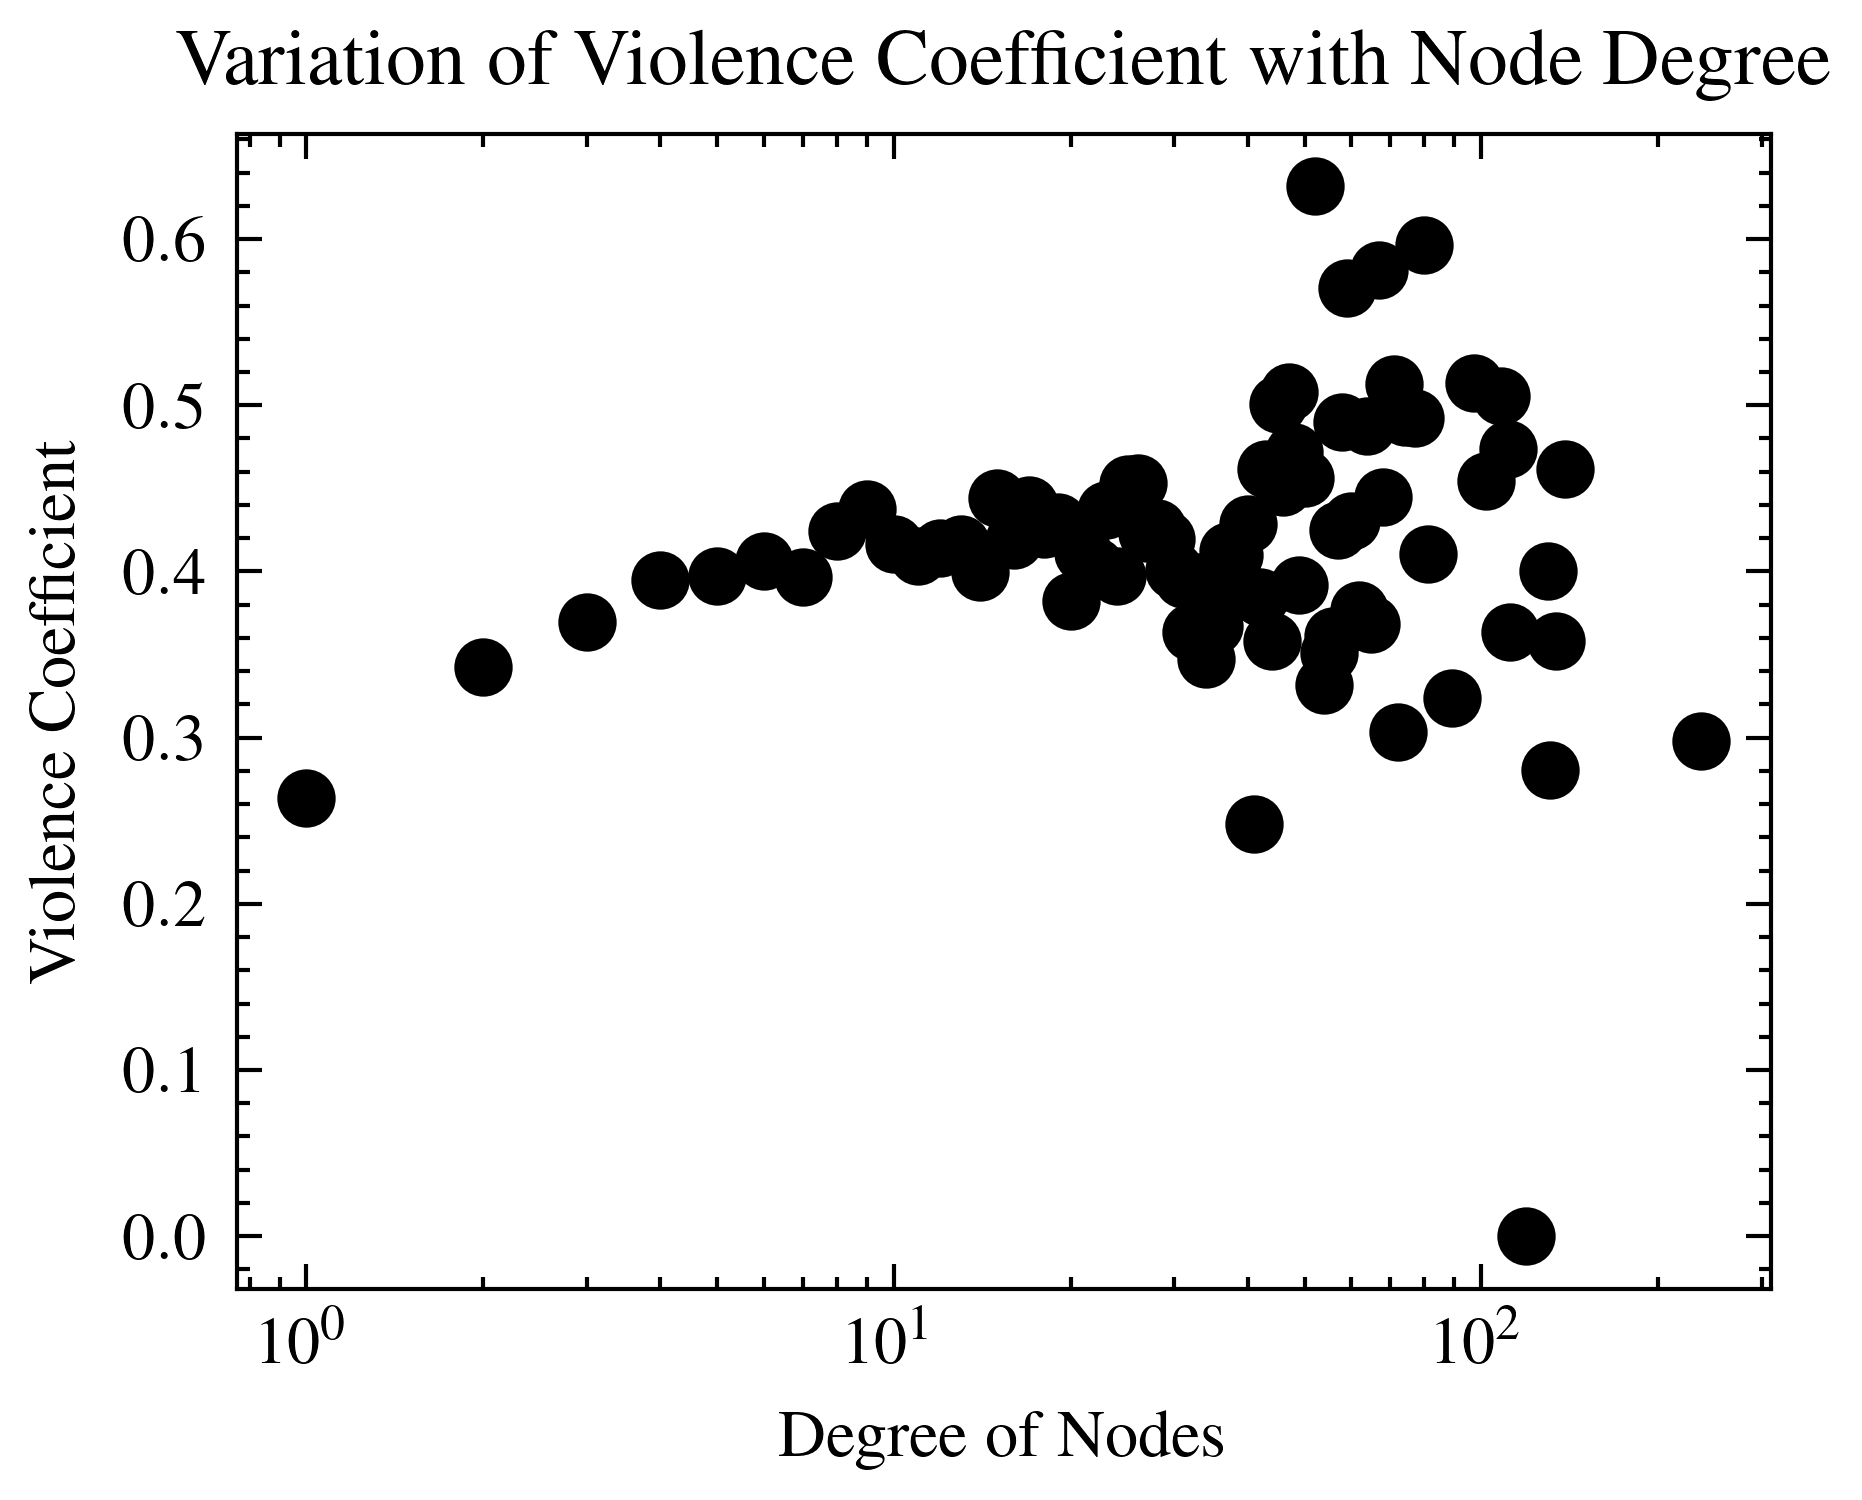

In [126]:
# Create a scatter plot
plt.scatter(list(degree_violence.keys()), [np.average(el) for el in list(degree_violence.values())])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree of Nodes')
plt.ylabel('Violence Coefficient')
plt.title('Variation of Violence Coefficient with Node Degree')
plt.show()

In [91]:
len([c > 4.79398462e-01 for c in eigenvector_centrality.values()])

18823

In [65]:
def draw_arrow_symbols(ax, symbols, x_coords, y_coords, xsize=0.1, ysize=0.1, color='k', lw=1):
    for symbol, x, y in zip(symbols, x_coords, y_coords):
        if symbol == '<':
            ax.plot([x-0.5*xsize, x + 0.5*xsize], [y, y + ysize], color=color, lw=lw, ls='solid')
            ax.plot([x-0.5*xsize, x + 0.5*xsize], [y, y - ysize], color=color, lw=lw, ls='solid')
        elif symbol == '>':
            ax.plot([x+0.5*xsize, x - 0.5*xsize], [y, y + ysize], color=color, lw=lw, ls='solid')
            ax.plot([x+0.5*xsize, x - 0.5*xsize], [y, y - ysize], color=color, lw=lw, ls='solid')


In [71]:
import scipy.stats as stats

def boxplot_compare_two_values_with_tests(values_dict, percentile_partition, type_of_value, stat_method=stats.mannwhitneyu, fig=None, ax=None):
    # If no figure or axis is provided, create a new one
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, 1)
    
    values = list(values_dict.values())
    # Calculate percentiles
    percentiles = np.percentile(values, percentile_partition)

    # Group values by percentiles
    value_by_percentile = [[] for _ in range(len(percentile_partition))]

    for node in G.nodes():
        value = values_dict[node]
        percentile_index = len(percentiles) - 1
        for i, p in enumerate(percentiles):
            if value < p:
                percentile_index = i
                break
        value_by_percentile[percentile_index].append(violence_coefficients.get(node, 0))
    to_plot_indices = [i for i in range(len(value_by_percentile)) if len(value_by_percentile[i]) != 0]
    # Create a boxplot
    flierprops = dict(marker='o', markerfacecolor='k', markersize=4, 
                      linestyle='none', alpha=0.5)

    boxplots = ax.boxplot([value_by_percentile[i] for i in to_plot_indices], 
                          labels=[f"{percentile_partition[i]}%" for i in to_plot_indices]
                          ,flierprops=flierprops)
    
    ax.set_xlabel(f'{type_of_value} Percentiles')
    ax.set_ylabel('Values')
    ax.set_title(f'Values by {type_of_value} Percentiles')
    ax.xaxis.set_minor_locator(plt.NullLocator())
    # Compare adjacent boxplots and mark significant differences
    num_boxes = len(boxplots['boxes'])
    y_max = max([max(data) for data in [value_by_percentile[i] for i in to_plot_indices] if data])
    
    for i in range(num_boxes - 1):
        data1 = value_by_percentile[to_plot_indices[i]]
        data2 = value_by_percentile[to_plot_indices[i + 1]]

        # Perform statistical test (e.g., Mann-Whitney U test)
        if data1 and data2:  # Ensure both groups have data
            stat, p_value = stat_method(data1, data2)
            if p_value < 0.05:  # Using 0.05 as the threshold for significance
                
                m1 = np.median(data1)
                m2 = np.median(data2)
                symbol = u"\u003C" if m1 < m2 else u"\u003E"  # Unicode for '<' and '>'
                sep = 0.35
                x1, x2 = i + 1 + sep, i + 2 - sep
                y = (m1 + m2)*0.5
                
                ax.plot([x1, x2], [y, y], lw=1.5, c='k', ls=(0, (1, 1)))
                ysize = 0.02*y_max
                xsize = 0.1
                draw_arrow_symbols(ax, [symbol], [(x1 + x2) * 0.5], [y+ysize+ysize],xsize=xsize, ysize=ysize)

    return fig, ax

(<Figure size 3600x3600 with 4 Axes>,
 <Axes: title={'center': 'Values by Eigenvector Centrality Percentiles'}, xlabel='Eigenvector Centrality Percentiles', ylabel='Values'>)

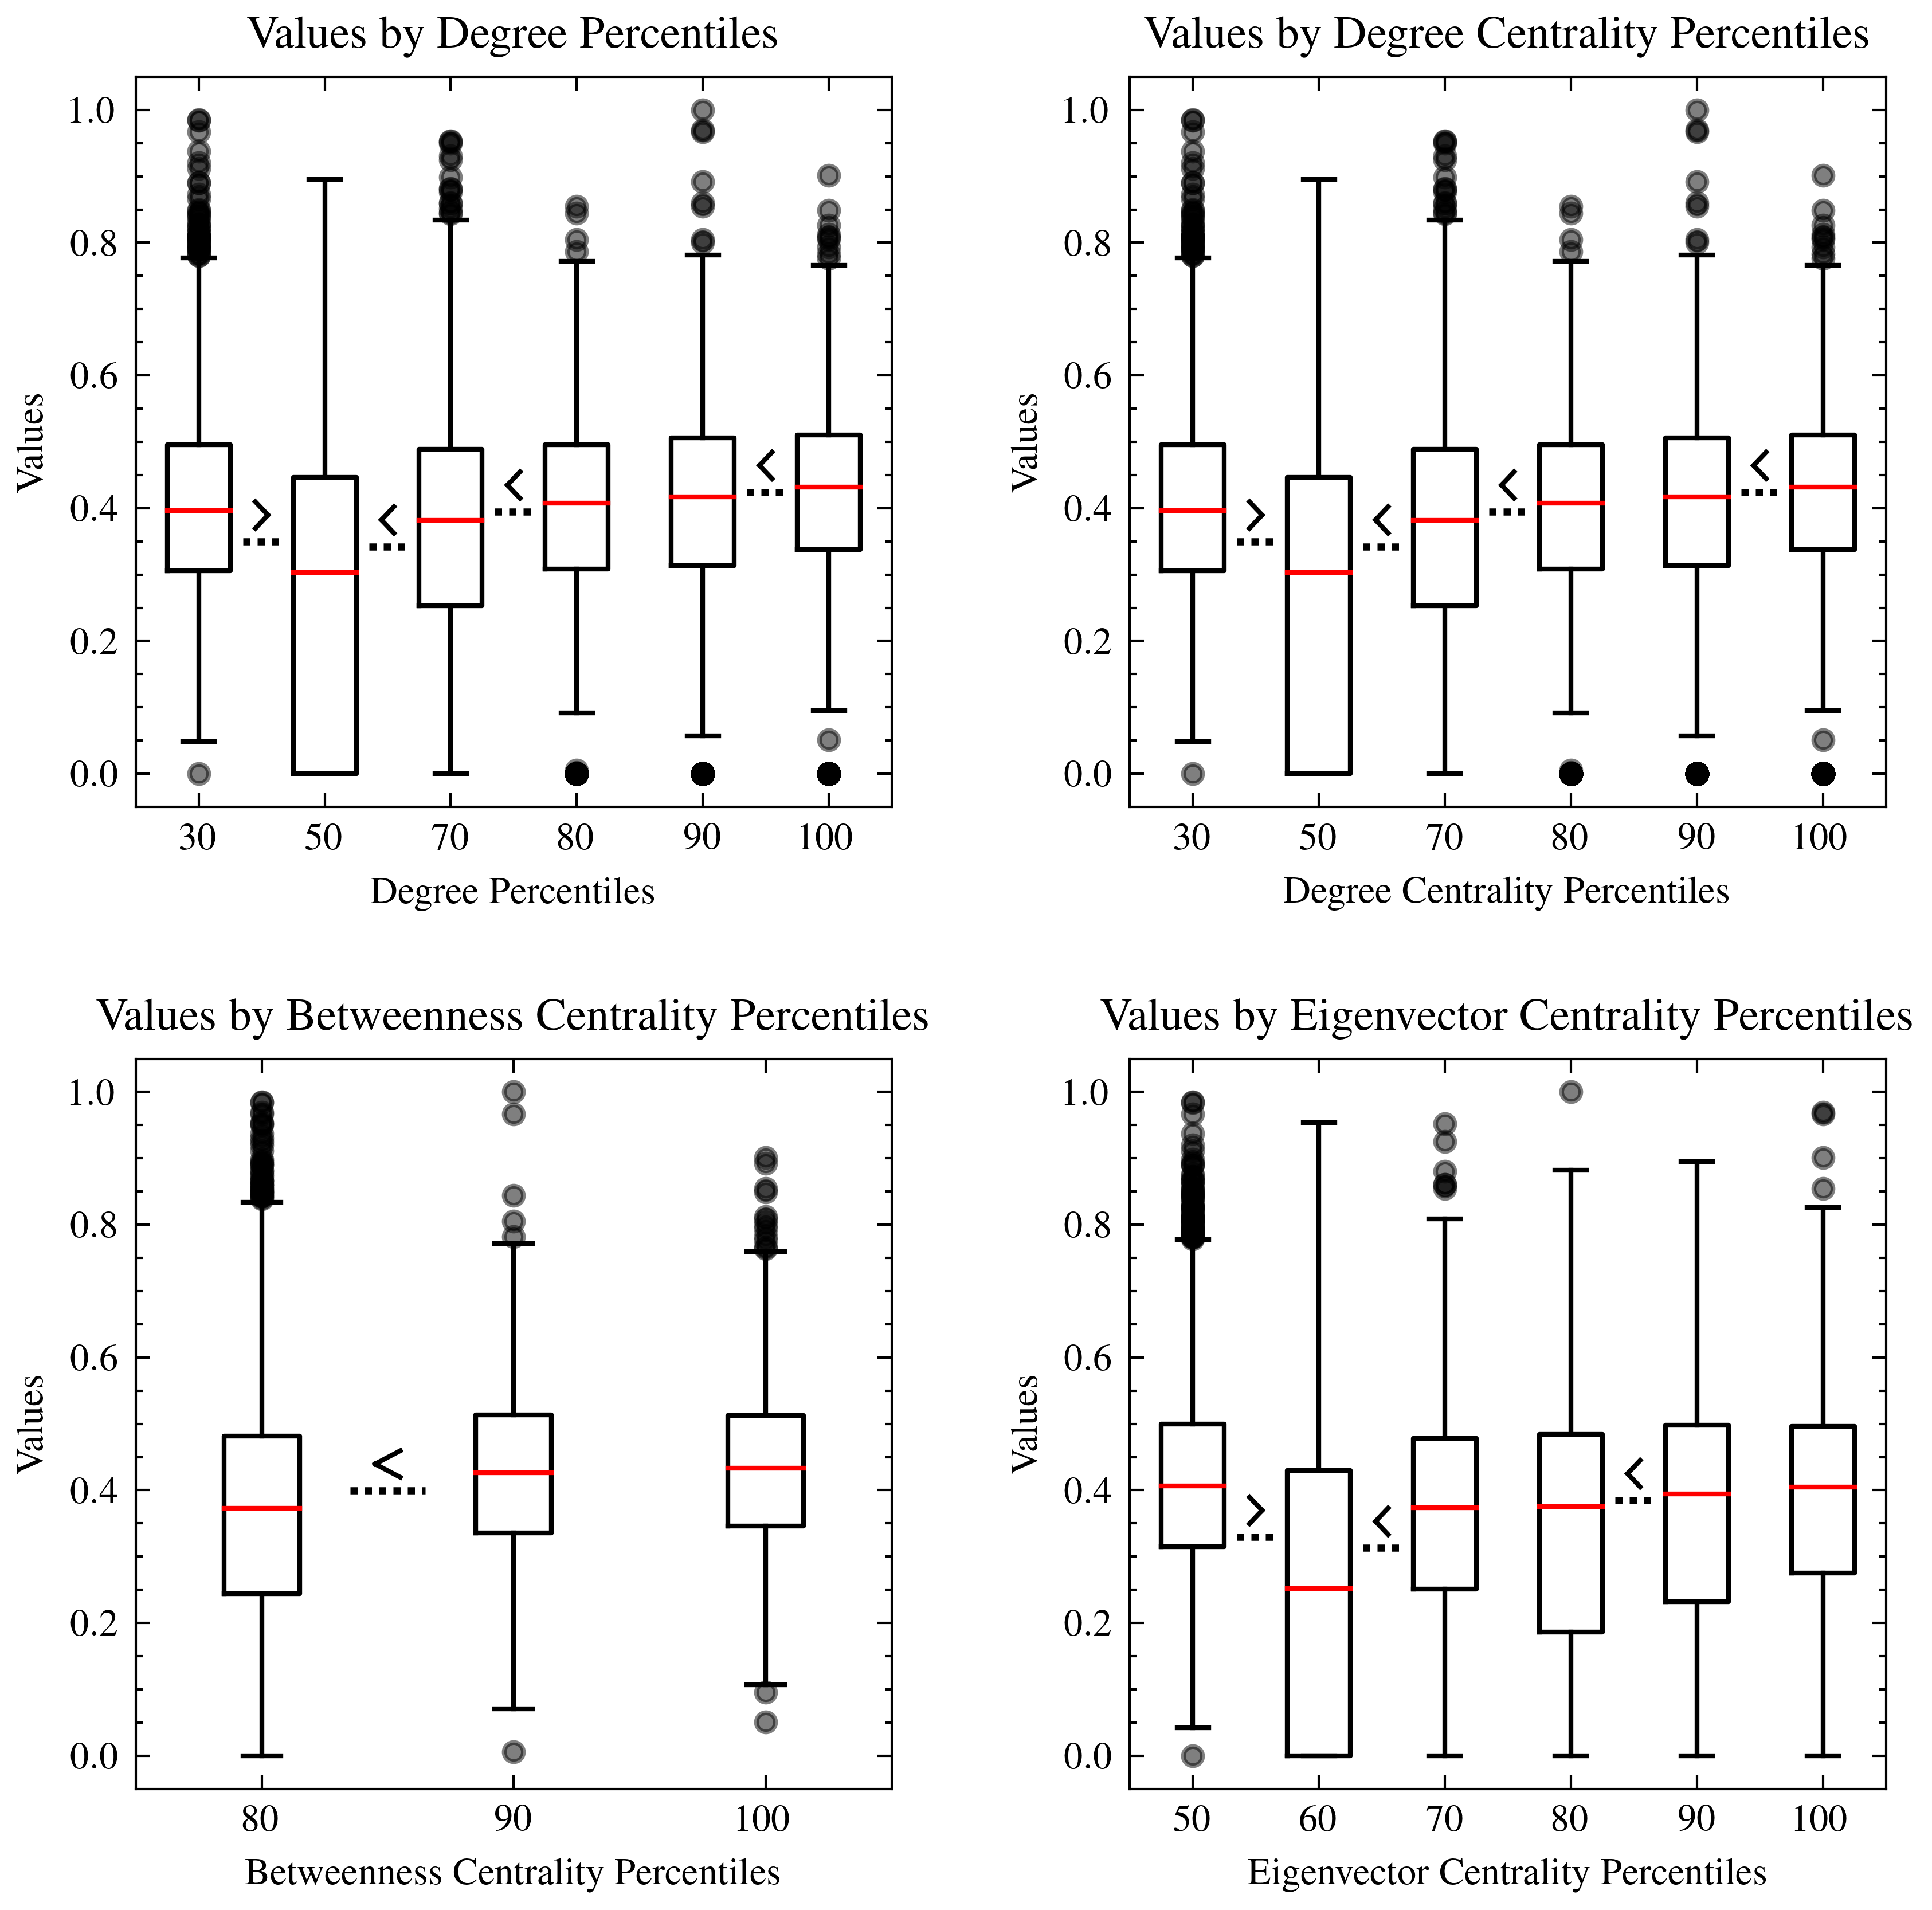

In [72]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
fig, ([ax0, ax1], [ax2, ax3]) = plt.subplots(2,2 )
fig.tight_layout()
fig.set_figwidth(6)
fig.set_figheight(6)


# Compute the degree of each node
degrees = dict(G.degree())

percentile_partition = [10, 20, 30, 40, 50 ,60, 70, 80, 90, 100]
# fig.suptitle("Boxplots")
boxplot_compare_two_values_with_tests(degrees, percentile_partition, "Degree", fig=fig, ax=ax0)
boxplot_compare_two_values_with_tests(degree_centrality, percentile_partition, "Degree Centrality", fig=fig, ax=ax1)
boxplot_compare_two_values_with_tests(betweenness_centrality, percentile_partition, "Betweenness Centrality", fig=fig, ax=ax2)
boxplot_compare_two_values_with_tests(eigenvector_centrality, percentile_partition, "Eigenvector Centrality", fig=fig, ax=ax3)


In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
fig.set_figwidth(12)
fig.set_figheight(3)

# Compute the degree of each node
degrees = dict(G.degree())

percentile_partition = [10, 20, 30, 40, 50 ,60, 70, 80, 90, 100]
fig.suptitle("Boxplots")
boxplot_compare_two_values_with_tests(degrees, percentile_partition, "Degree", stat_method=stats.kruskal, fig=fig, ax=ax0)
boxplot_compare_two_values_with_tests(degree_centrality, percentile_partition, "Degree Centrality", stat_method=stats.kruskal, fig=fig, ax=ax1)
boxplot_compare_two_values_with_tests(betweenness_centrality, percentile_partition, "Betweenness Centrality", stat_method=stats.kruskal, fig=fig, ax=ax2)
boxplot_compare_two_values_with_tests(eigenvector_centrality, percentile_partition, "Eigenvector Centrality", stat_method=stats.kruskal, fig=fig, ax=ax3)